#1. 들어가며

이미지 파일을 업로드하여 비슷한 이미지들을 찾을 수 있다는 사실을 아시나요?

오늘 우리는 주로 OpneCV를 통한 이미지 다루기에 대해 알아볼 것입니다.

그런 후 우리는 이와 유사한 기능을 실제로 만들어볼 예정입니다.

물론 오랜 시간 데이터를 축적해 왔고, 다양한 이미지 검색 기법을 사용한 구글과 같은 검색 성능을 기대할 수는 없겠지만, 우리는 색상 히스토그램을 기반으로 주어진 이미지들 중 비슷한 색상 분포를 가지고 있는 이미지를 찾아주는 기능을 구현해 보겠습니다.


이를 위한 본 노드의 **학습목표**는 다음과 같습니다.
- 컴퓨터에서 이미지가 표현되는 방식을 이해한다.
- Pillow와 OpenCV로 Python 에서 이미지 파일을 열고 정보를 추출할 수 있다.
- CIFAR-100에서 히스토그램을 기반으로 유사한 이미지를 골라낼 수 있다.

오늘은  이미지 분야의 다양한 실습이 예정되어 있습니다.

아래와 같이 실습 환경을 준비해 주세요.

우선 아래와 같이 필요한 라이브러리를 설치합니다.

순서대로 Pillow, OpenCv, Matplotlib 입니다.

대부분은 그동안의 실습을 통해 이미 설치되어 있을지도 모릅니다.

In [36]:
!pip install pillow opencv-python matplotlib

아래와 같이 설치디렉토리를 구성하고 실습용 파일 하나를 다운로드 받습니다.

In [37]:
!mkdir -p~/aiffel/python_image_proc
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/pillow_practice.png
!mv pillow_practice.png ~/aiffel/python_image_proc

mkdir: invalid option -- '~'
Try 'mkdir --help' for more information.
--2021-05-28 12:40:41--  https://aiffelstaticprd.blob.core.windows.net/media/documents/pillow_practice.png
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 621125 (607K) [image/png]
Saving to: ‘pillow_practice.png.1’

pillow_practice.png 100%[===================>] 606.57K   918KB/s    in 0.7s    

2021-05-28 12:40:42 (918 KB/s) - ‘pillow_practice.png.1’ saved [621125/621125]

mv: cannot move 'pillow_practice.png' to '/root/aiffel/python_image_proc': No such file or directory


그리고 오늘 실습용으로 사용될 CIFAR-100 이미지 데이터셋을 다운로드 합니다. Tensorflow에서 제공하는 것이 아닌, 실제 이미지 파일을 포함하는 버전입니다.

In [38]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/cifar-100-python.tar.gz
!mv cifar-100-python.tar.gz~/aiffel/python_image_proc
!cd~/aiffel/python_image_proc && tar xvzf cifar-100-python.tar.gz

--2021-05-28 12:40:42--  https://aiffelstaticprd.blob.core.windows.net/media/documents/cifar-100-python.tar.gz
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/gzip]
Saving to: ‘cifar-100-python.tar.gz.1’

cifar-100-python.ta 100%[===================>] 161.17M  8.54MB/s    in 27s     

2021-05-28 12:41:09 (6.04 MB/s) - ‘cifar-100-python.tar.gz.1’ saved [169001437/169001437]

mv: missing destination file operand after 'cifar-100-python.tar.gz~/aiffel/python_image_proc'
Try 'mv --help' for more information.
/bin/bash: cd~/aiffel/python_image_proc: No such file or directory


#2. 디지털 이미지

디지털 화면은 수많은 점들로 이루어져 있으며 ,색상을 가지는 점 하나를 **화소**(pixel, picture element) 라고 합니다.

각 화소는 **RGB(Red, Green, Blue) 세 개의 단일 색의 강도를 각각 조절하여 색상을 표현합니다. 근데 왜 하필 세 개의 색일까요?

이는 눈의 망막에 있는 시세포가 인간의 경우 대부분 세가지로 이루어져 있기 때문입니다. 

아래 그림은 각 종류의 시세포가 반응하는 색상 영역을 나타냅니다. 

특이하게도 일부 인간들과 일부 새들은 시세포 종류가 하나씩 더 있어서, 색을 조금 더 세밀하게 인식하거나 일부 자외선 영역을 감지할 수 있습니다.

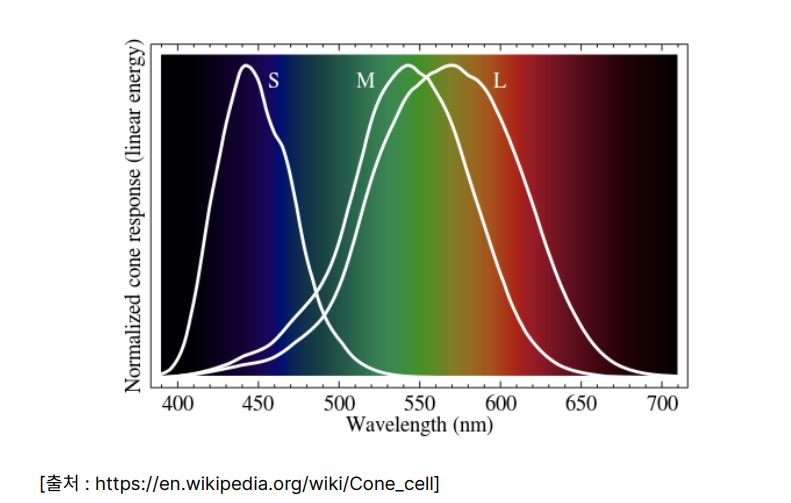

이렇게 빨강, 초록, 파랑 세가지 색의 강도로 표현되는 점들로 구성된 디지털 화면에 표시될 이미지를 저장하는 방법중 가장 단순한 방법은,

**각 점 하나 하나의 색상 값을 저장하는 방식** 입니다.

이를 **래스터(raster)** 또는 **비트맵*(bitmap)** 방식의 이미지라고 하며, 보통 한 점마다 각 색상별로 8비트를 사용하여 0~255 사이의 값 (2^8 = 256)으로 해당 색의 감도를 표시합니다.

반면에 **벡터**(vector)방식의 이미지는 상대적인 점과 선의 위치를 방정식으로써 기록해 두었다가, 확대 및 축소에 따라 디지털 화면의 각 화소에 어떻게 표현될지를 재계산 하기에 깨짐이 없습니다. 

우리가 주로 다루는 파일들 중에는 사진 파일들이 래스터 방식이며, 확대 축소가 자유로이 가능한 글꼴들이 주로 벡터 방식입니다.

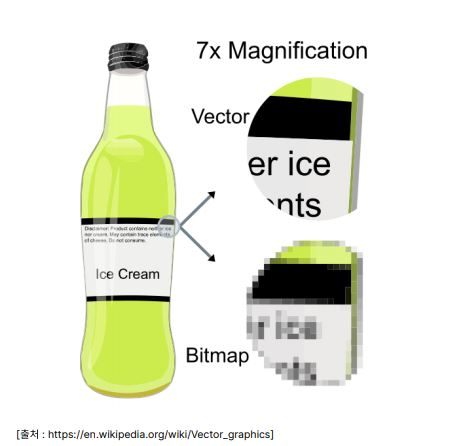

결국에는 디지털 화면의 화소로 표시되는 이미지를 저장하는 방법이 여러가지인 것처럼, 결국에 RGB로 표시되는 색상값도 꼭 RGB 형식으로만 저장될 필요는 없습니다.

예를 들어 흑백(grayscale) TV 시절에서 컬러 TV로 넘어가던 시절에는 , 인간의 눈이 색상의 차이보다는 음영에 더 민감한 것을 역이용하여, 기존 흑백 채널에다가 그보다 1/4 해상도를 가진 두 색상 채널을 덧붙여서 송출하는 **YUV**방식(아래 사진)이 사용되었습니다.

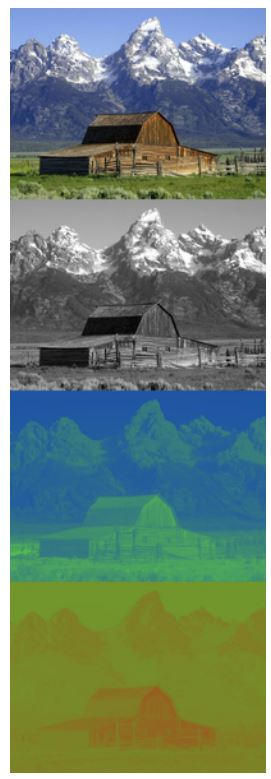

[출처 : https://en.wikipedia.org/wiki/YUV

또한 디지털 화면에서 색감을 수치적으로 조작할 때 조금 더 직관적으로 이해할 수 있는 **HSV(Hue 색상, Saturation 채도, Value 명도)도 자주 사용됩니다.

이외에 인쇄 매체의 경우에는 색의 강도를 높일 수록 어두워진다는 특성과, 또한 자주 사용되는 검정색을 표현할 때 각 색을 조합하면 잉크의 낭비가 심하다는 현실적인 이유 때문에,

RGB가 아닌 **CMYK**(Cyan, Magenta, Yellow, Black) 네 가지 색상을 사용합니다.

이렇게 색을 표현하는 다양한 방식을 각각 **컬러 스페이스**(color space, 색공간)라고 하며, 각 컬러스페이스를 구성하는 단일 축(RGB에서의 각각 R,G,B)을 **채널**(channel)이라고 합니다.

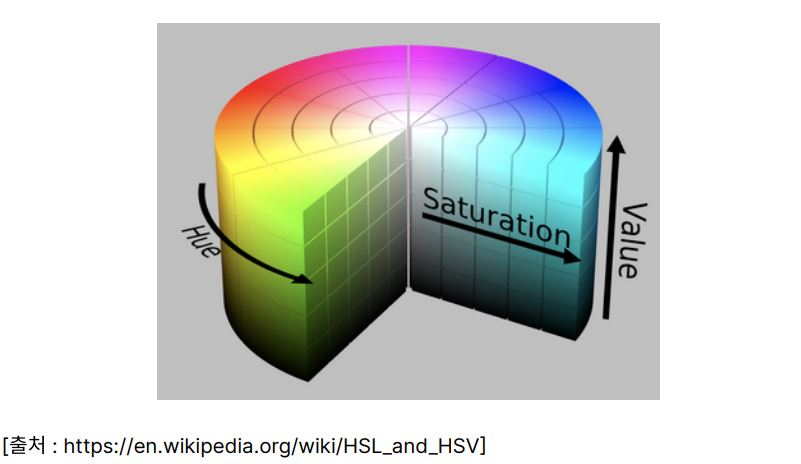

하지만 이러한 색상 정보를 그대로 저장하기에는 생각보다 많은 용량을 차지합니다.

따라서 사진저장에 흔히 쓰이는 JPEG 이미지 형식의 경우 근처에 있는 화소들을 묶어, 비슷한 색들을 뭉뚱그리는 방식으로 이미지를 압축합니다.

이러한 방식에는 색상 정보의 손실이 있기에, 저장할 때 압축률을 높이거나, 여러번 다시 저장하는 등 재압축이 일어나게 될 경우, 흔히 디지털 풍화라고 불리는 색상이 지저분해지는 현상을 볼 수 있습니다.

이와 반대로 스크린샷 등에 많이 사용되는 PNG 이미지 형식의 경우 색상의 손실 없이 이미지를 압축하는데, 이미지에 사용된 색상을 미리 정의해두고 그를 참조하는 팔레트 방식을 사용할 수 있기에, 사용된 색상이 적은 단순한 이미지의 경우 동일한 해상도의 JPEG 파일보다도 용량이 작을 수 있지만, 사진과 같이 이미지에 사용된 색상이 많아지면 JPEG파일보다 쉽게 더 많은 용량을 차지합니다.

이외에 움짤로 익숙한 GIF 형식의 이미지는 이미지 내에 여러 프레임을 두어 이를 움직이게 만들 수 있고, 또한 색상 정보를 손실 없이 저장하나, 256개의 색상만 기억할 수 있는 팔레트 방식으로 제한됩니다.



#3. Pillow 사용법

옛날 옛적에 파이썬에서의 이미지 처리를 위해 PIL(Python Image Library)이라는 라이브러리가 있었습니다. 

하지만 이 라이브러리는 2011년 마지막 커밋을 이후로 개발이 중단도이었습니다.

대신 이 정신을 Pillow가 이어받아 현재까지도 지속적으로 이어져 내려오고 있습니다.

오늘 학습의 주인공은 Pillow가 아니라 OpenCV입니다.

그러나 간단한 이미지 작업에 Pillow는 Numpy와 결합하여 간편하게 사용할 수 있는 도구입니다. 오늘 우리는 먼저 간단히 Pillow 사용법을 살펴보고 오늘 실습 데이터인 CIFAR-100 데이터를 전처리 하는 작업을 진행해 보려고 합니다.


PIL을 이용해 바로 이미지 하나를 직접 생성해 보겠습니다.

명심할 점은 결국 이미지는 **배열 형태의 데이터** 라는 점입니다. 

예를들어 가로 세로 각 32픽셀에 RGB 세 가지 색상 채널이 있다면,

Numpy로 [32,32,3] 차원의 배열을 생성하면 됩니다. 또한 데이터 타입을 uint8, 즉 값이 부호가 없는 (unsigned) 8비트 정수(integer)가 되어 0~255(2의 8승 =256) 사이의 값을 나타내도록 해야 합니다.



In [39]:
import numpy as np
from PIL import Image

data = np.zeros([32,32,3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')
image.show()

어떤가요? 아주 작은 32*32짜리 까만 이미지 화면이 떳나요? 어쩜 너무 작아서 눈에 잘 안띄셨을지도 모르겠네요.

만들어진 배열을 PIL.Image.fromarray() 를 통해 바로 이미지 객체로 변환한 뒤, .show()메서드를 통해서 화면에 표시했습니다. np.zeros()로 초기화된 모든 픽셀의 모든 채널의 값이 0이기 때문에 검정색 이미지가 나왔지만, 이번에는 모든 픽셀이 빨간색의 값을 가지도록 해 보겠습니다.

In [40]:
data[:, :] = [255, 0, 0]
image = Image.fromarray(data,'RGB')
image.show()

**연습문제**
1. 가로 세로 각 128 픽셀 짜리 흰색 이미지를 만들어 화면에 표시해 봅시다.

In [41]:
data = np.zeros([128, 128, 3], dtype=np.uint8)
data[:, :] = [255, 255, 255]
image = Image.fromarray(data, 'RGB')
image.show()

연습용 이미지 파일을 열어서 다양하게 가공해 봅시다. import 시 pillow가 아닌 PIL을 사용한다는 점에 유의합시다.

### 2. 연습용 이미지를 열어 width와 height를 출력하고, .save()를 이용하여 jpg파일 포맷으로 저장해 봅시다.


In [42]:
#-문제2-#
from PIL import Image
import os

#연습용 파일 경로
image_path = '/content/pillow_practice.png'

#이미지 열기
img = Image.open(image_path)
img.show()

#width와 height 출력
print(img.width)
print(img.height)

#JPG 파일 형식으로 저장해보기
new_image_path = '/content/pillow_practice.jpg'
img = img.convert('RGB')
img.save(new_image_path)

620
465


3. resize()를 이용하여 이미지 크기를 100*200 으로 변경하여 저장해 봅시다

In [43]:
resized_image = img.resize((100,200))
resized_image.show()

resized_image_path = '/content/pillow_practice_resized.png'
resized_image.save(resized_image_path)


**4. crop()을 이용하여 눈 부분만 잘라내어 저장해 봅시다.**


In [44]:
box = (300, 100, 600, 400)
region = img.crop(box)
region.show()

cropped_image_path = '/content/pillow_practice_cropped.png'
region.save(cropped_image_path)

#4. pillow 를 활용한 데이터 전처리

**CIFAR-100 데이터를 받아 개별 이미지 파일로 추출하기**

이미지 데이터베이스 구축을 위해 

https://www.cs.toronto.edu/~kriz/cifar.html

**CIFAR-100 데이터셋**을 활용해 보겠습니다.

32x32화소 해상도의 이미지들이 100개 클래스 당 600장(각 학습용 500장, 테스트용 100장) 하여 총 60,000장 있습니다.

우리가 오늘 사용할 데이터셋은 CIFAR-100 ptyhon version 이라고 되어있는 파일 입니다.

우리는 첫 스텝에서 이미 해당 파일을 다운로드 받아서 압축 해제까지 진행하였습니다.

압축 해제된 결과를 보면 이미지 파일들이 아니라 meta, test, train 이라는 세 뭉텅이만 나옵니다.

우리는 이 중 train 파일만 사용하여, 본문 중 Dataset layout 아래 Python/ Matlab version 섹션중 

python3 버전에 따라 한번 파일을 열어봅시다. 그렇게 해서 추출된 내용(return dict에 의해 반환된 내용) 을 train 이라고 하고 한번 들여다 봅시다.

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import pickle

dir_path = '/content/drive/MyDrive/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
  train = pickle.load(f, encoding='bytes')

print(type(train))
print(train)
#혹시 내용이 궁굼하다면 주석을 풀고 실행해 보세요.

<class 'dict'>
{b'filenames': [b'bos_taurus_s_000507.png', b'stegosaurus_s_000125.png', b'mcintosh_s_000643.png', b'altar_boy_s_001435.png', b'cichlid_s_000031.png', b'phone_s_002161.png', b'car_train_s_000043.png', b'beaker_s_000604.png', b'fog_s_000397.png', b'rogue_elephant_s_000421.png', b'computer_keyboard_s_000757.png', b'willow_tree_s_000645.png', b'sunflower_s_000549.png', b'palace_s_000759.png', b'adriatic_s_001782.png', b'computer_keyboard_s_001277.png', b'bike_s_000682.png', b'wolf_pup_s_001323.png', b'squirrel_s_002467.png', b'sea_s_000678.png', b'shrew_s_002233.png', b'pine_tree_s_000087.png', b'rose_s_000373.png', b'surveillance_system_s_000769.png', b'pine_s_001533.png', b'table_s_000897.png', b'opossum_s_001237.png', b'quercus_alba_s_000257.png', b'leopard_s_000414.png', b'possum_s_002195.png', b'bike_s_000127.png', b'balmoral_castle_s_000361.png', b'acer_saccharinum_s_000646.png', b'lapin_s_000916.png', b'chimp_s_001419.png', b'clock_s_002291.png', b'streetcar_s_000663

train 내용을 그대로 화면에 출력하면 한꺼번에 너무 많은 내용이 나와 갈피를 잡기가 힘들 것입니다.

다시 본문으로 돌아가 이어지는 내용("Loaded in this way, each of the batch files contains a dictionary")에 따르면 파이썬의 dictionary 객체이니, 일단 어떤 키들이 있는지 한번 살펴 봅니다.

In [47]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

특이사항으로는 각 키들이 문자열(str)이 아닌 b로 시작하는 bytes로 되어있다는 점입니다. 이에 유의하면서 일단 파일명(b'filenames')들을 한번 살펴봅시다.

In [48]:
type(train[b'filenames'])

list

역시 기대했던 대로 list로군요. 앞의 5개만 출력해 봅시다.

In [49]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

파일 이름이 깔끔하게 나왔습니다. 이 파일 이름에 해당하는 이미지는 어디 있을까요?

다시한번 본문을 참고해 봅시다.

    data -- a 10000x3072 numpy array of uint8s. Each row of the
    array stores a 32x32 colour image. The first 1024 entries contain
    the red channel values, the next 1024 the green, and the final
    1024 the blue. The image is stored in row-major order, so that
    the first 32 entries of the array are the red channel values of the
    first row of the image.

딕셔너리에 b'data' 를 보라는 말 같습니다. 한번 첫 번째를 꺼내 봅시다.

In [50]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [51]:
train[b'data'][0].shape

(3072,)

이 숫자와 위 본문을 보니, 3072라는 숫자는 빨강 초록 파랑 3채널 X1024(=32*32)씩 각 화소에 해당하는 것 같습니다.

그렇다면 이 Numpy 배열을 잘 reshape 하면 이미지 파일 원본이 복구된다는 뜻입니다.

그럼 (32,32,3)으로 reshape한 후 이미지를 화면에 출력해 봅시다.

주의해야 할 게 하나 있습니다. 위에 언급된 바를 상기해 보면, 3072바이트의 이미지 데이터는 앞 1024바이트는 빨강(R), 그다음 1024는 녹색(G), 마지막 1024는 파랑(B)으로 되어 있습니다.

RGB순서가 맞는 것은 다행이지만, 그렇다고 그냥 모양만 맞추어 reshape 하면 안됩니다.

1024를 32x32에 채우는 것을 3번 반복하는 방식의 reshape여야 합니다.

이렇게 앞선 차원부터 데이터를 채우는 방식의 reshape를 위해 

np.reshape에는 **order**라는 인자가 있습니다.

이 값을'**F**'로 주면 원하는 형태로 진행 됩니다.

In [52]:
image_data = train[b'data'][0].reshape([32, 32, 3],order='F') #order를 주의하세요!!
image = Image.fromarray(image_data)
#Pillow를 사용하여 Numpy 배열을 Image 객체로 만들어서
image.show() #화면에 띄워 봅시다!!

어떻습니까? 사이즈는 작지만 멋진 이미지가 나온 것 같습니다.

그런데 눈썰미가 좋으신 분이라면 갸우뚱 하실 것입니다. 

이미지의 X축과 Y축이 뒤집어져 나오고 있습니다. 

축을 바꿔주는 작업이 필요합니다.

여기에는 np.swapaxes(0, 1)이 유용합니다.

In [53]:
image_data = image_data.swapaxes(0,1)
image = Image.fromarray(image_data)
image.show()

자, 이렇게 CIFAR-100의 데이터 셋 원본을 분석해서 이미지 파일을 뽑아내는 것 까지 진행해 보았습니다. 그러나 우리는 이미지 파일을 실제 파일처럼 만들어 놓고 싶습니다.

게이터셋에 파일명과 파일 데이터 배열이 순서를 따라 저장되어 있는 것을 확인하였으니, 차례차례 Numpy 배열로 읽어서 이를 이미지 파일로 저장해 주는것은 이전 스텝에서 배운 내용으로 충분할 것 같습니다.


In [54]:
import os
import pickle
from PIL import Image
import numpy
from tqdm import tqdm

dir_path = '/content/drive/MyDrive/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

#image를 저장할 cifar-100-python의 하위 디렉토리(images)를 생성합니다.
images_dir_path = os.path.join(dir_path, 'images')
if not os.path.exists(images_dir_path):
  os.mkdir(images_dir_path) #images 디렉토리 생성


#32X32의 이미지 파일 50000개를 생성합니다.
with open(train_file_path, 'rb') as f:
  train = pickle.load(f, encoding='bytes')
  for i in tqdm(range(len(train[b'filenames']))):
    filename = train[b'filenames'][i].decode()
    data = train[b'data'][i].reshape([32, 32, 3], order='F')
    image = Image.fromarray(data.swapaxes(0,1))
    image.save(os.path.join(images_dir_path, filename))

100%|██████████| 50000/50000 [05:05<00:00, 163.78it/s]


#5. OpenCV (1) 안녕, OpenCV

**OpenCV**는 오픈소스로 제공되는 컴퓨터 비전용 라이브러리 인데요.

C++, Python, Java, MATLAB 등 다양한 언어에서 호출하여 사용할 수 있으며, 영상 처리에 대한 다양한 고급 기능들이 사용하기 쉽도록 구현되어 있습니다.

파이썬 튜토리얼 페이지에 들어가면 여러가지 고급 예제들이 친절하게 설명되어 있는데, 우리는 이중에 이미지에서 특정 색을 가진 영역만 추출하는 예제를 한번 살펴 보겠습니다.

Changing Colorspaces

Pillow의 실습에서 보았듯, 이미지는 결국[너비, 높이, 채널] 형태를 가지는 배열이고, 컴퓨터 비전이란 결국 이러한 배열 형태의 데이터를 처리하는 것이 중요한 분야 라는것을 배웠습니다.

이미지의 내용 중 우리가 관심있는 부분이 특정 색을 가지고 있다면, 이 정보를 통해 원하는 부분을 배경으로 구분하고, 원하는 부분만 따로 떼어낼 수 있습니다.
이 예제에서는 카메라를 통해서 영상을 읽어들이고, 파란색을 찾기 쉽도록 컬러스페이스를 BGR(RGB)에서 HSV로 변환한뒤, 해당 색상과 맞는 영역에만 표시하는 작업이 진행됩니다.

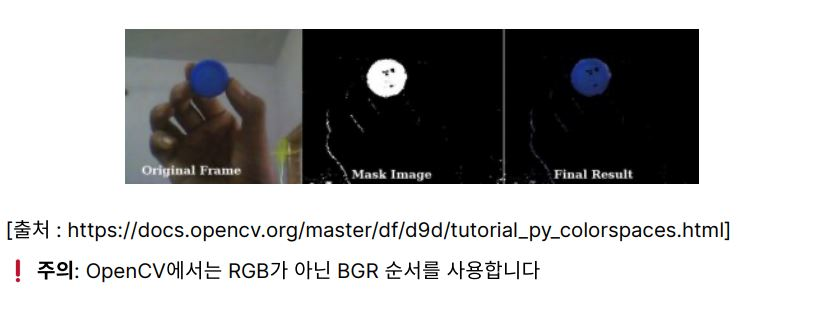


**연습 문제**

- 우선 아래 예제의 전체 코드를 한번 살펴보시고, 5분 정도 주석 및 코드에 미루어 전체 흐름을 동작해 작동을 추측해보려고 합니다. 그리고 다음 스텍으로 넘어가 한줄 한줄 설명을 읽고 추측 했던 내용과 맞춰봅시다.

-일단 아래 코드를 그냥 한번 돌려봅시다. 동작의 개요를 파악한 후, 당황하지말고, **[ESC]를 눌러** 떠 있는 창들을 모두 닫아 줍시다.



In [55]:
import cv2 as cv
import numpy as np

cap = cv.VideoCapture(0)

while(1):
  #Take each frame
  _, frame = cap.read()

  #Convert BGR to HSV
  hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
  
  #define range of blue color in HSV
  lower_blue = np.array([110, 50, 50])
  upper_blue = np.array([130,255,255])

  #Threshold the HSV image to get only blue colors
  mask = cv.inRange(hsv, lower_blue, upper_blue)
  
  #Bitwise-And mask and orignal image
  res = cv.bitwise_and(frame,frame, mask=mask)
  cv.imshow('frame', frame)
  cv.imshow('mask', mask)
  cv.imshow('res',res)
  k = cv.waitKey(5)&0xFF
  if k == 27:
    break

cv.destroyAllWindows()
cap.release()

error: ignored

❗ 주의: 혹시 다른 프로세스가 카메라를 점유하고 있다면 위 코드 실행 시 오류가 발생할 수 있습니다. 카메라 사용 프로세스를 모두 종료 후 위 코드를 실행해 주세요.

#6. OpenCV(2)

자, 전체 코드를 한번 살펴볼 시간을 가지셨다면 이제 한 조각씩 함께 읽어보도록 하겠습니다.
(조금 호흡이 길 수도 있으니 스트레칭 한 번 하고 시작해 보세요)


    import cv2 as cv
    import numpy as np

 OpenCV 는 pip으로 설치 시 opencv-python 이라는 이름으로 설치해야 하는데, import 할 때는 cv2 라는 이름을 씁니다.

 하지만 실제 버전은 4.x대 입니다. 복잡하지만 여러 가지 역사적인 사정이 겹쳐서 이렇게 되었습니다.

 OpenCV와 함께, 숫자 배열을 처리하는데 궁합이 잘 맞는 Numpy도 불러옵니다. 

 생각해보면 이미지 데이터는 숫자 행렬입니다. 예를 들어 가로세로 각 32 픽셀의 이미지가 있다면, 이는 32x32 행렬이고, 컬러 이미지의 경우 각 픽셀마다 RGB에 각각 해당하는 세 개의 숫자가 있기에, 32x32x3의 배열이 됩니다.

    cap = cv.VideoCapture(0)

VideoCapture라는 함수를 호출했습니다. 무엇을 하는 함수 일까요?

한번 OpenCV 공식 문서화 사이트를 참조해봅시다.
https://docs.opencv.org/4.3.0/d8/dfe/classcv_1_1VideoCapture.html#aabce0d83aa0da9af802455e8cf5fd181


사실 알고보면 OpenCV는 Python 전용으로 개발된 것이 아니라 C++, Java, Matlab 등에서 함께 사용이 가능하도록 만들어 졌는데요. 모든 언어에 대해 문서화를 하나로 통합하여 제공하기에 그렇답니다.

스크롤을 위 아래로 올려보면 같은 VideoCapture에 대한 설명도 3개가 있습니다. 자세히 보면 입력 매개변수가 각각 다른데(filename, index 등 ), 이는 C++이나 Java에서는 동일한 이름의 함수라도 매개변수가 다르면 별개의 함수로써 정의할 수 있기 때문입니다.

이를 overloading이라 하는데, Python에서는 신경 쓸 필요가 없으나 유의하여 문서를 읽어봅시다.

위의 예제 코드에서는 VideoCapture에 대한 입력값으로 0이라는 정수(int)를 입력했으니, intindex를 입력값으로 받는, 즉 정수형의 index라는 매개변수를 입력으로 받는 VideoCapture()의 정의를 살펴보면 됩니다.

"Opens a camera for video capturing.
This is an overloaded member function, provided for convenience.

It differs from the above function only in what arguent(s)

it accepts."

간단히 해석해보면, 영상 캡쳐를 위해 카메라를 여는 함수이며, 동일한 이름으로 매개변수만 바뀐채 위의 함수와 동일한 기능을 제공한다고 합니다.

이어서 그 아래의 Parameters 중 index 값에 대한 설명을 보면 다음과 같습니다.

"id of the video capturing device to open. To open defalult camera using defalut backend just pass 0.(..생략..)"

영상을 캡쳐할 장치의 ID라고 합니다. 0을 입력하면 기본 카메라가 제공된다고 합니다.

카메라가 열렸고, 이제 계속 진행해 보겠습니다.


    while(1):
    #Take each frame
    _,frame = cap.read()

while(1):을 통해 이하 코드를 계속 반복 하도록 설정합니다.

while True: 가 사실 더 올바른 표기 이긴 합니다.

그아래 줄에서 아까 VideoCapture()를 통해서 열었던 카메라 객체 cap에 .read()메서드를 호출합니다.

여기서 출력을 _,frame 두개를 받는데, 앞의 _의 경우 안쓰고 버릴 값을 받는 관습(convention)상의 변수입니다. 

과연 뭘 받았길래 필요가 없었던 걸까요?

다시 동일한 문서에서 한번 read() 메서드를 찾아 순서대로 읽어봅시다.

virtual bool

cv::VideoCapture::read(OutputArray image)

C++상의 API입니다. 굳이 이해할 필요는 없지만 살짝 설명하자면, C++의 경우 Python과는 달리 개발자가 직접 변수에 할당할 메모리를 관리해야 하기 때문에,
Python 처럼 read() 메서드가 알아서 필요한 메모리를 잡고 이미지 데이터를 써서 반환하는 것이 아니라, 개발자가 직접 이미지를 받을 OutputArray를 메모리상에 만들어 이 함수에 전달해주면, read() 메서드는 해당 위치에 이미지 데이터를 써주기만 하는 형식으로 동작하게 됩니다.

잘 이해가 안 되었어도 괜찮습니다.

우리에게 필요한 Python 용 설명으로 넘어 갑시다.

Python:
retval, image = cv.VideoCapture.read([,image)

Python의 경우 cv.VideoCapture.read() 메서드도 C++과 마찬가지로 image 라는 값을 입력값으로 받을 수 있지만, 이는 선택적([])이기에 굳이 필요하지는 않습니다.

그리고 함수의 반환값은 retval(return value의 줄임말)과 image 두가지 입니다.

설명을 계속 읽어보면, 
"Grabs, decodes and returns the next video frame."

다음 영상 프레임을 잡아 이미지 데이터로 디코딩하여 반환하는 함수라고 합니다.

입력값 또는 매개변수(parameters)로 받는 image는 위에서 설명한 바와 같이, 영상이 쓰여질 객체라고 합니다.

retval의 정체가 여기 있습니다. 만약 카메라가 연결이 해제되는 등의 상황으로 인해 프레임이 잡히지 않는다면 false가 반환 된다고 합니다.

즉 , 예제 코드로 돌아가서 다시 살펴보면,

    while(1):
    #Take each frame
    _,frame - cap.read()

우리는 retval이 관심이 없으니 버린카드(_)라는 이름으로 받고, 필요한 영상 이미지만 frame 이라는 제대로 된 변수명으로 받아서 나중에 쓰겠다는 뜻이 됩니다.

다시 예제 진도를 나가 보겠습니다.

    #ConvertBGR to HSV
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

cvtColor은 컬러 스페이스 변환(convert)을 위한 함수입니다. 이제 문서를 읽는 법은 어느정도 배웠으니 직접이해해 봅시다.

https://docs.opencv.org/master/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab

이제 이어지는 다음 부분이 중요합니다.

    #define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130, 255, 255])

    #Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_blue, upper_blue)

숫자로 파란색이라는 부분을 정의하고, 이 값들을 기준으로 이미지에서 마스크를 생성하는 과정 입니다.

여기서 마스크란 수채화를 그리거나 인테리어 공사중 실리콘을 바를 때 사용하는 마스킹 테이프의 역할과 동일합니다. 

우리가 원하는 부분만을 떼어낼 수 있도록 하는 역할입니다.

위 코드에서는 HSV색 공간에서 색상(Hue)값 110~130 사이, 채도(Saturation) 및 명도(Value)값 50~255사이의 색들을 파란색이라고 정의하고 있습니다. 그리고 아까 frame 영상을 변환한 hsv에다가 이 기준들(lower_blue, upper_blue)를 적용하여, 해당하는 픽셀들에는 1, 그렇지 않은 픽셀들에는 0을 찍어놓은 배열을 반환하는 것이 cv.inRange()의 역할입니다.

즉, 우리가 가로 400, 세로 300 픽셀짜리 이미지를 받았었다면, frame과 hsv는 각각 픽셀당 BGR, HSV 세 개의 색상 체널별 값을 가질 테기 때문에, 400*300*3 의 크기를 갖는 배열이었고, mask는 픽셀마다 1 또는 0만을 값으로 가졌기에 400*300(*1)의 크기를 갖게 됩니다.

아래 이미지의 왼쪽 중 original frame으로 mask를 만든 뒤 1을 흰색으로, 0을 검정으로 표시한다면, 아래 이미지의 가운데에 있는 mask image와 동일하게 됩니다.

그럼 이제 오른쪽처럼 선택한 부분만 오려내야 겠죠?
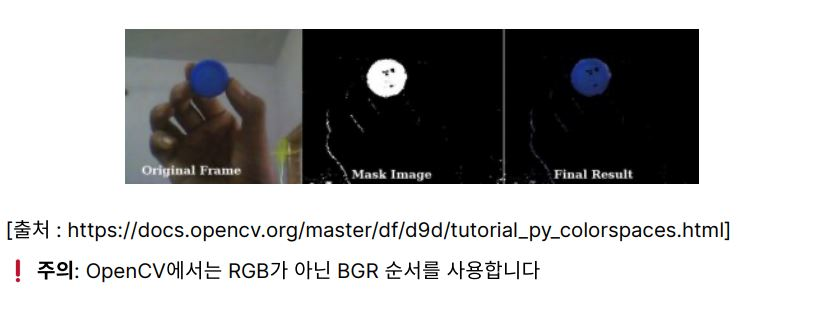

    #bitwise-AND mask and original image
    res = cv.bitwise_and(frame,frame, mask=mask)

cv.bitwise_and() 에 대한 설명은 https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14

좀 복잡하니 한번 슬쩍만 보고 오세요.

결국 이미지 두장을 받아서 AND 비트 연산을 한다는 건데, 우리는 이 기능이 필요한 게 아니니 두장 다 같은 이미지(frame, frame)를 넣어서 결국 동일한 이미지가 나오게 합니다.

대신 중요한 mask를 같이 넣어줘서, 해당 영역만 따오도록 합니다.

따온 영역은 위 공식문서 페이지의 함수 설명에 따라 dst가 주어진다면 그 위에, 아니면 새로 빈 검정색 영역위에 이미지를 만들고 반환 합니다.

남은 부분은 직관적 입니다.

      cv.imshow('frame',frame)
      cv.imshow('mask',mask)
      cv.imshow('res', res)
      k = cv.waitkey(5) & 0xFF
      if k == 27:
          break

    cv.destroyAllWindows()

cv.imshow()는 PIL.Image.show()와 마찬가지로 이미지를 화면에 표시해줍니다.
각각 카메라에서 받아온 이미지 frame, 파란색인 영역만 골라낸 마스크 mask, 그리고 이미지에 마스크를 적용한 결과 res를 표시하도록 합니다. 이후에 cv.waitKey(5)를 통해서 5초간 키 입력을 감지하고, 키 입력이 특정키(27번=ESC)가 되면 처음의 무한루프(while1)애서 빠져나오되, 아니라면 다시 위로 돌아가서 카메라를 읽는 부분부터 반복하게 됩니다.

마지막으로 cv.destroyAllWindows()를 통해 열려있던 창들을 모두 닫으며 예제는 끝납니다.

**연습 문제**

    Q1. & 0xFF는 어떤 역할을 하는 코드일까요?
    Numlock을 제거합니다. 자세한 설명은 링크를 참고하세요.

    https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1/39201163#392011

    

#7. 실습: 비슷한 이미지 찾아내기

**CIFAR-100 이미지중 비슷한 이미지 찾아내기**

우리는 OpenCV에서 제공하는 기능 중에서 **이미지에서 색상 히스토그램을 추출하고, 이를 서로 비교하는 기능들** 을 불러 사용해 보겠습니다. **히스토그램**이란, 이미지에서 픽셀 별 색상값의 분포 라고 볼 수 있습니다. 즉, 우리는 이러한 히스토그램을 통해, 각 이미지의 색상분포를 비교하여 서로 유사한 이미지를 판단하는 척도로 사용할 예정입니다.

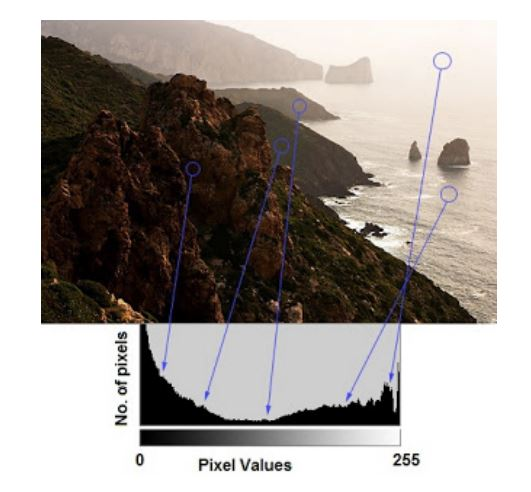


[출처 : https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html]

위의 예시는 이미지를 흑백으로 변환했을 때 밝기에 따른 히스토그램이지만, 우리는 RGB 각 채널별 분포를 사용하려 합니다. 

 

또한, 0 ~ 255 사이 각 값에 해당하는 픽셀의 개수를 일일이 저장하기에는 계산량이 많아지므로, 단순화의 측면에서 이를 4개 구간(0 ~ 63, 64 ~ 127, 128 ~ 191, 192 ~ 255)로 나누어 픽셀 수를 세기로 합니다.

우리가 사용할 OpenCV 자체는 C++로 구현되어 있고, 이를 파이썬에서 불러 쓸 수 있도록 하는 패키지인 opencv-python을 설치해야 합니다.

또한 히스토그램을 실제로 화면에 표시하기 위해 matplotlib도 설치되어야 합니다.

우리는 첫번째 스텝에서 아래 과정을 진행 했습니다.

    !pip install opencv-python matplotlib

위에서 저장해둔 CIFAR-100 이미지 중 하나를 골라서, 아래 OpenCV예제 페이지의 Plotting Histograms 중 Using Matplotlib내 색상별 히스토그램을 그리는 코드를 참조하여 히스토 그램을 그려 봅시다.



In [61]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

#전처리 시 생성했던 디렉토리 구조
dir_path = '/content/drive/MyDrive/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')
images_dir_path = os.path.join(dir_path, 'images')

In [63]:
#파일명을 인자로 받아 해당 이미지 파일과 히스토그램을 출력해 주는 함수

def draw_color_histogram_from_image(file_name):
  image_path = os.path.join(images_dir_path, file_name)
  # 이미지 열기
  img = Image.open(image_path)
  cv_image = cv2.imread(image_path)

  #Image와 Histogram 그려보기
  f=plt.figure(figsize=(10,3))
  im1 = f.add_subplot(1,2,1)
  im1.imshow(img)
  im1.set_title("Image")

  im2 = f.add_subplot(1, 2, 2)
  color = ('b', 'g', 'r')
  for i, col in enumerate(color):
    #image 에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
    histr = cv2.calcHist([cv_image], [i], None, [256], [0, 256])
    im2.plot(histr, color = col) #그래프를 그릴 때 채널 색상과 맞춰서 그립니다.
  im2.set_title("Histogram")

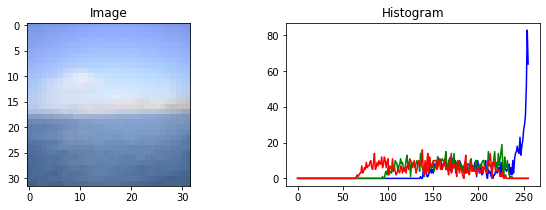

In [64]:
draw_color_histogram_from_image('adriatic_s_001807.png')

#STEP1. 아이디어 개요

자, 그럼 이제 설계를 한번 해 봅시다!

우리가 만들 결과물은 histogram_search.py 라는 Python 파일이고, 이 파일은 이미지 파일 경로 하나를 명령줄에서 입력으로 받아, 검색 대상 이미지들 중 비슷한 이미지들을 골라 화면에 표시하는 기능을 수행한다고 생각해봅시다.

이런 생각을 어떻게 동작하는 코드로써 구체화시킬 수 있을까요?

원하는 모든 부분이 명확해질 때까지 계속 스스로에게 질문하고, 직접 답을 찾는 방식으로 진행해 봅시다.

우선 위에 정의한 기능에 있어서 가장 핵심적인 질문이라면, 아무래도 '비슷한 이미지'라는 개념을 어떻게 컴퓨터가 이해하도록 하느냐 일 겁니다.

이미지의 유사성을 정의하고 측정하는 방법에는 무한한 방법이 있을 수 있겠지만, 오늘 우리는 위에서 배운 히스토그램이라는 개념을 통해 이미지를 서로 비교할 예정입니다.

히스토그램을 만들어 주는 함수 cv2.calcHist()와 마찬가지로, 히스토그램끼리의 유사성을 계산해 주는 기능 역시 OpenCV에서 제공해주는 cv2.compareHist()라는 함수를 사용해서 해결할 겁니다.

그럼 나머지 작은 기술적인 질문들이 남습니다. 이미지 파일 경로를 명령줄에서 입력으로 받는것은 어떻게 하지? sys.argv를 사용하면 됩니다. 검색 대상 이미지는 어디서 가져오지? 위에서 준비했던 CIFAR-100 이미지들을 사용해 봅시다.

기능에 대한 질문들이 어느 정도 해소가 되었다면, 이제 코드의 구조에 대해서 생각해 볼 차례입니다. 직접 코드를 자기 전에 우선 사람의 말로 한번 pseudo-code를 자봅시다.

아울러 처음부터 모든 세세한 부분까지 다 잡아내려 하지말고, 우선은 큼직한 흐름부터 잡아낸 뒤에, 여러 번 반복을 거쳐서 살을 붙여 나갑시다.

위의 기능을 토대로 한번 간단한 작동 순서를 생각하면 다음과 같이 정리해 볼 수 있을 겁니다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 표시한다.
- 프로그램이 종료된다.

#STEP2. 아이디어 구체화

위의 내용을 어떻게 더 구체화할 수 있을까요? 일단 이미지 5개를 표시하기 위해서는 그 이미지 5개를 선택해야 합니다. 당장은 의미 없어 보일지 몰라도 이렇게 아주 조금씨기아도 생각을 진행해 나갑시다.

- 프로그램이 실행된다
- 입력된 경로의 이미지 파일을 불러온다
- **검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.**
- **고른 이미지들을 표시한다.**
- 프로그램이 종료된다.

다시 여태 나온 과정을 뚫어져라 쳐다보면, 가운데의 "가장 비슷한 이미지 5개 고르기"만 가장 복잡하고 구체화되지 않았다는 느낌이 강하게 옵니다. 이 줄을 어떻게 더 쪼갤 수 있을까요?

우선 입력된 경로의 이미지를 불러온 것처럼, 검색 대상 이미지들도 결국 불러와야 비교할 수 있을 것 같습니다. 또한 가장 비슷한 이미지 5개를 고르려면, 유사도를 어떻게는 숫자로 표현한 뒤, 순서를 매기고 위에서부터 자르면 될 것 같습니다.
- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.
    - **검색 대상 이미지들을 불러온다.**
    - ** 입력 이미지와 비교하여 유사도를 기준으로 순서를 매긴다.**
    - **유사도 순서상으로 상위 5개 이미지를 고른다.**
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

#STEP3. 핵심 알고리즘 유사도 계산 방법

자, 한걸음 더 구체적으로 만들어 봅시다. 유사도를 기준으로 순서를 매기려면 결국 유사도를 계산해야 합니다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다.
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.
  - 검색 대상 이미지들을 불러온다
  - 입력 이미지와 비교하여 유사도를 기준으로 순서를 매긴다
    - **입력 이미지와 검색 대상 이미지들 사이의 유사도를 계산한다.**
    - **계산된 유사도를 기준으로 정렬하여 순서를 매긴다.**
  - 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.
  그리고 우리는 유사도를 히스토그램끼리 비교할 것이고, 여기에는 OpenCV의 기능을 사용할 예정이라고 했습니다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다.
- 검색 대상 이미지들 중 불러온 이미지와 가장 비슷한 이미지 5개를 고른다.
  - 검색 대상 이미지들을 불러온다.
  - 입력 이미지와 비교하여 유사도를 기준으로 순서를 매긴다.
    - **입력 이미지와 검색 대상 이미지들 사이의 유사도를 계산한다.**
      - **입력 이미지와 검색 대상 이미지들을 하나 하나 히스토그램으로 만든다.**
      - **OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나 하나의 히스토그램간 유사도를 계산한다.**
    - **계산된 유사도를 기준르로 정렬하여 순서를 매긴다.**
  - 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

#STEP4. 기능의 모듈화

짠! 이제 우리가 무엇을 구현할 지 충분히 구체화된 것 같습니다.

구상이 끝났으니 한번 깔끔하게 정리해 봅시다.

- 프로그램이 실행된다
- 입력된 경로의 이미지 파일을 불러온다.
- **검색 대상 이미지들을 불러온다.**
- **입력 이미지를 히스토그램으로 만든다.**
- **검색 대상 이미지들을 하나하나 히스토그램으로 만든다.**
- **OpenCV의 compareHist()함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다.**
- **계산된 유사도를 기준으로 정렬하여 순서를 매긴다**
- **유사도 순서상으로 상위 5개 이미지를 고른다**
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

우리의 설계가 좀 더 코드스러워 지도록, 유관한 단계들을 묶어 함수들로 만들어 봅시다.

- 프로그램이 실행된다.
- 입력된 경로의 이미지 파일을 불러온다.
- 입력 이미지를 히스토그램으로 만든다.
- build_histogram_db()
  - **검색 대상 이미지들을 불러온다**
  - **검색 대상 이미지들을 하나하나 히스토그램으로 만든다.**
- search()
  - **OpenCV의 compareHist()함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다.
  - **계산된 유사도를 기준으로 정렬하여 순서를 매긴다.**
  - **유사도 순서상으로 상위 5개 이미지를 고른다.**
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

자 여기서 조금 더 원활한 실습을 위해, 우리의 설계가 조금 더 단순해 지도록 기능을 살작 제한해 보겠습니다. 아무 이미지나 입력 받는게 아니라 , 검색 대상이었던 CIFAR-100 이미지 중 하나의 이름을 입력받는 것으로 대체해 봅시다.

- 프로그램이 실행된다.
- build_histogram_db()
  - CIFAR-100 이미지들을 불러온다.
  - CIFAR-100 이미지들을 하나하나 히스토그램으로 만든다
- **CIFAR-100히스토그램중 입력된 이미지 이름에 해당하는 히스토그램을 입력 이미지로 선택한다.
- search()
  - OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산한다.
  - 계산된 유사도를 기준으로 정렬하여 순서를 매긴다.
  - 유사도 순서상으로 상위 5개 이미지를 고른다.
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

#STEP5. 설계 과정 완성

그럼 마지막 단계로, 각 함수에 입력되고 반환될 데이터의 형태와 변수명을 한번 정해 봅시다.
- 프로그램이 실행된다.
- build_histogram_db()
  - CIFAR-100 이미지들을 불러온다.
  - CIFAR-100 이미지들을 하나하나 히스토그램으로 만든다.
  - **이미지 이름을 키로 하고, 히스토그램을 값으로 하는 딕셔너리 histogram_db를 반환한다.**
- **CIFAR-100 히스토그램 중 입력된 이미지 이름에 해당하는 히스토그램을 입력 이미지로 선택하여 target_histogram 이라는 변수명으로 지정한다.**
- search()
  - **입력 이미지 히스토그램 target_histogram과 전체 검색 대상 이미지들의 히스토그램을 가진 딕셔너리 histogram_db를 입력으로 받는다.**
  - **OpenCV의 compareHist() 함수를 사용하여 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램간 유사도를 계산한다. 결과는 result라는 이름의 딕셔너리로, 키는 이미지 이름, 값은 유사도로 한다.**
  - 계산된 유사도를 기준르로 정렬하여 순서를 매긴다.
  - **유사도 순서상으로 상위 5개 이미지만 골라서 result에 남긴다.**
- 고른 이미지들을 표시한다.
- 프로그램이 종료된다.

#STEP6. 코드로 구현

여기까지 해서 설계 과정이 끝났습니다.

따라오기 어렵거나 쉽게 이해되지 않는 부분이 있었다 하더라도, 우리는 처음이기에 걱정할 필요는 없습니다. 사람마다 사고방식도 물론 다르고, 또한 무엇보다 어느 부분을 어떻게 구체화해야 하는지, 어떤 부분을 함수로 묶고 어떻게 데이터로 표현할지는 많은 연습이 필요하기 때문 입니다. 따라서 우리 실습의 마무리도 위내용를 직접 처음부터 코드를 구현하는 것이 아닌, 위 설계에 따라 이미 어느정도 쓰여진 코드의 빈칸을 완성하는 형태로 진행할 예정입니다.

그럼 위 설계된 내용을 하나씩 진행해 봅시다.

우선 build_histogram_db()를 구현해 볼 텐데, 지난 스텝에서 이미지를 특정 디렉토리에 모두 모아 둔 바 있습니다. 그 디렉토리에 있는 모든ㅇ ㅣ미지 파일을 대상으로 히스토그램을 만들어야 하는데, 우선 이미지 파일 1개에 대해 히스토그램을 만드는 함수를 만들어 보면 좋겠습니다. 이때 위에서 언급한 것 처럼 단순화의 측면에서 이를 4개 구간 (0 ~ 63, 64~ 127, 128~ 191, 192~ 255)로 나누어 픽셀 수를 세기로 한 바 있습니다. 이를 감안하여 다음과 같이 함수를 만듭니다.



In [65]:
def get_histogram(image):
  histogram = []

  #Create histograms per channels, in 4 bins each.
  for i in range(3):
    channel_histogram = cv2.calcHist(
        images=[image],
        channels=[i],
        mask=None,
        histSize=[4],
        #히스토그램 구간을 4개로 한다.
        ranges=[0, 256])
    histogram.append(channel_histogram)

  histogram = np.concatenate(histogram)
  histogram = cv2.normalize(histogram, histogram)

  return histogram
  

In [66]:
#get_histogram() 확인용 코드
filename = train[b'filenames'][0].decode()
file_path = os.path.join(images_dir_path, filename)
image = cv2.imread(file_path)
histogram = get_histogram(image)
histogram

array([[0.3126804 ],
       [0.4080744 ],
       [0.14521089],
       [0.21940625],
       [0.18654831],
       [0.23742512],
       [0.30208108],
       [0.35931748],
       [0.06465594],
       [0.35825753],
       [0.36991683],
       [0.29254165]], dtype=float32)

get_histogram()이 정상 동작한다면, 이제 본격적으로 build_histogram_db()를 구현해 보겠습니다.

In [68]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def build_histogram_db():
  histogram_db ={}

  #디렉토리에 모아 둔 이미지 파일들을 전부 리스트업 합니다.
  path = images_dir_path
  file_list = os.listdir(images_dir_path)
  
  for file_name in tqdm(file_list):
    file_path = os.path.join(images_dir_path, file_name)
    image = cv2.imread(file_path)
    histogram = get_histogram(image)

    histogram_db[file_name] = histogram
  
  return histogram_db

방금 만든 build_histogram_db()을 실행, 검증해 봅시다.

잘 만들어 졌다면, 이 함수가 리턴할 객체 histofram_db는 

histogram_db['adriatics001807.png']을 호출했을 때 12x1의 Numpy 배열을 리턴해야 합니다.

In [69]:
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png']


100%|██████████| 49999/49999 [01:40<00:00, 499.93it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

이제 histogram_db가 완성되엇습니다. 다음으로는 target_histogram에 입력받은 이미지의 히스토그램을 저장하는 함수를 만들겠습니다.

파이썬 모듈에서는 sys.argv[1] 에 검색하고 싶은 이미지 파일명을 입력받게 됩니다만, 우리는 아래와 같이 Input으로 직접 입력 받아 봅시다.

In [70]:
def get_target_histogram():
  filename = input("이미지 파일명을 입력하세요: ")
  if filename not in histogram_db:
    print('유효하지 않은 이미지 파일명입니다.')
    return None
  return histogram_db[filename]

In [71]:
target_histogram = get_target_histogram()
target_histogram

KeyboardInterrupt: ignored

이제 search 함수를 만들어봅시다. 설계 단계에서 우리가 만들 searchㅘㅁ수는 입력 이미지 히스토그램 target_histogram와 전체 검색 대상 이미지들의 히스토그램을 가진 딕셔너리 histogram_db를 입력으로 받는다고 하였습니다. 입력부가 다 정의되었으므로, 구현 후 출력 까지 가능하곘습니다. 입력부에 유사도 순으로 몇 개 까지 결과에 남길지 top_k=5라는 파라미터를 하나 추가해 주겠습니다.


In [73]:
def search(histogram_db, target_histogram, top_k=5):
  results ={}
  #Calculate similarity distance by comparing histograms
  for file_name, histogram in tqdm(histogram_db.items()):
    distance = cv2.compareHist(H1=target_histogram,
                               H2=histogram,
                               method=cv2.HISTCMP_CHISQR)
    result[file_name] = distance
  
  results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

  return results

In [75]:
result = search(histogram_db, target_histogram)
result

NameError: ignored

이제 거의 다 왔습니다!! 

입력받은 이미지 파일과 가장 유사한 상위 5개의 이미지가 아주 빠르게 검색되어 나왔습니다. 

1번째는 당연히 입력 받은 이미지 그 자신이겠죠?

그럼 5개의 이미지가 얼마나 실제로 유사한지 시각화를 통해 알아보는 것만 남았습니다.

result를 입력받아 5개의 이미지를 화면에 출력하는 함수를 제작해 봅시다.


In [76]:
def show_result(result):
  f=plt.figure(figsize=(10,3))
  for idx, filename in enumerate(result.keys()):
    img_path = os.path.join(images_dir_path, filename)
    im = f.add_subplot(1, len(result), idx+1)
    img = Image.open(img_path)
    im.imshow(img)

In [77]:
show_result(result)

NameError: ignored

마지막으로 지금까지의 작업을 총 정리 하겠습니다.

검색할 이미지를 INput으로 받으면 즉시 가장 유사한 이미지가 화면 에 출력되는 코드입니다.

In [78]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)

KeyboardInterrupt: ignored